In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy
from collections import Counter
from matplotlib.font_manager import FontProperties

# 数据探索

In [2]:
df_train = pd.read_csv("D:\\a_lyj\\projects\\nlp\\text-classification\\project2_news_classification\\examples\\data\\train_set.csv", sep="\t")
df_test = pd.read_csv("D:\\a_lyj\\projects\\nlp\\text-classification\\project2_news_classification\\examples\\data\\test_a.csv", sep="\t")


## 1、简单查看数据

In [3]:
df_train.head()

,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


In [4]:
len(df_train)

200000

In [5]:
len(df_train["text"][0]), type(df_train["text"][0])

(5120, str)

## 2、定义一个函数，按行、以空格切分成整数列表，计算列表长度，然后查看长度数据分布特征

In [6]:
def split_df(df_row):
    return len(str(df_row).split())

len_dist = np.vectorize(split_df)(df_train["text"])
len_test_dist = np.vectorize(split_df)(df_test["text"])
len_dist, len_test_dist

(array([1057,  486,  764, ..., 1180,  179, 2098], shape=(200000,)),
 array([ 607, 1861,  901, ...,  299,  470,  245], shape=(50000,)))

（1）使用describe函数查看训练集、测试集中的数据长度分布

结论：从25%、50%、75%结果来看，训练集、测试集数据分布一致

In [7]:
pd.Series(len_dist).describe()

count    200000.000000
mean        907.207110
std         996.029036
min           2.000000
25%         374.000000
50%         676.000000
75%        1131.000000
max       57921.000000
dtype: float64

In [8]:
pd.Series(len_test_dist).describe()


count    50000.000000
mean       909.844960
std       1032.313375
min         14.000000
25%        370.000000
50%        676.000000
75%       1133.000000
max      41861.000000
dtype: float64

（2）通过直方图查看(频次、概率密度)

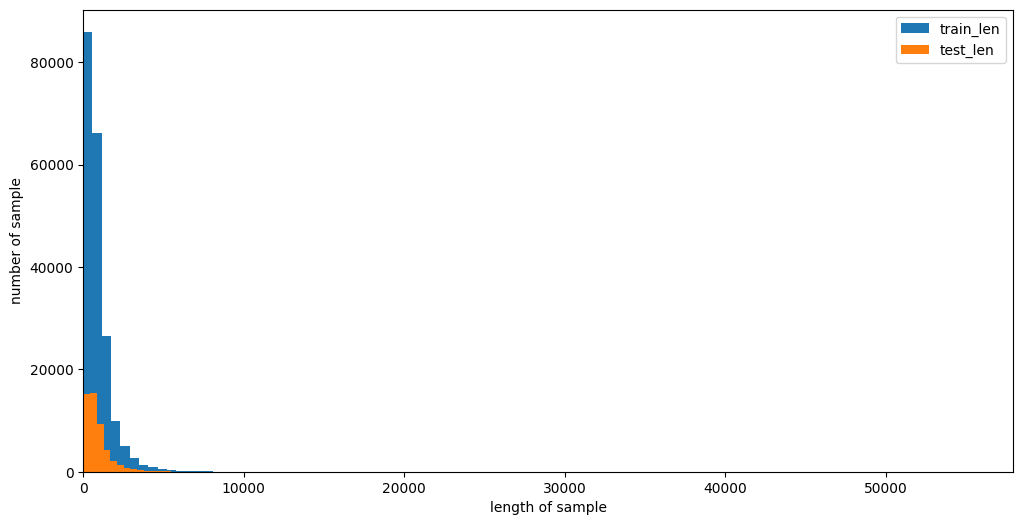

In [9]:
# 1. 创建图表和坐标轴
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# 2. 在同一个坐标轴上叠加直方图
ax = plt.hist(x=len_dist, bins=100)
ax = plt.hist(x=len_test_dist, bins=100)

# 3. 设置图表属性
plt.xlim([0, max(max(len_dist), max(len_test_dist))])
plt.xlabel("length of sample")
plt.ylabel("number of sample")
plt.legend(["train_len", "test_len"])

plt.show()

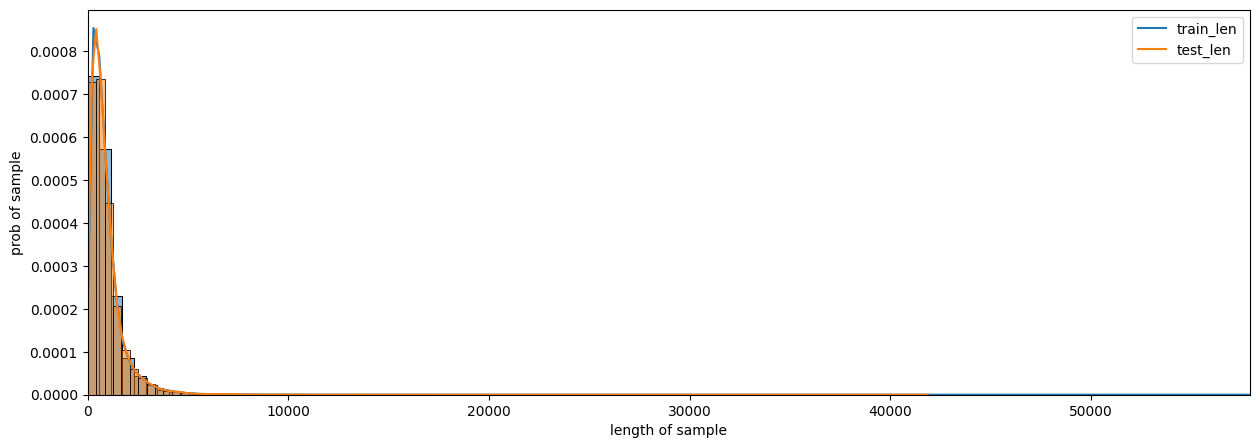

In [10]:
plt.figure(figsize=(15,5))
ax = sns.histplot(len_dist, bins=100, kde=True, stat="density")
ax = sns.histplot(len_test_dist, bins=100, kde=True, stat="density")
plt.xlim([0, max(max(len_dist), max(len_test_dist))])
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_len','test_len'])


（3）同分布验证（训练集、验证集）

scipy.stats.ks_2samp 是 SciPy 库中用于执行 两样本 Kolmogorov-Smirnov 检验（简称 KS 检验）的函数，主要用于判断两个样本是否来自相同的概率分布。以下是详细解释：

功能说明

两样本 KS 检验通过比较两个样本的经验累积分布函数（ECDF），计算它们之间的最大差异（即 KS 统计量），并通过这个差异判断两个样本是否来自同一分布。

原假设（H₀）：两个样本来自相同的概率分布。
备择假设（H₁）：两个样本来自不同的概率分布。

返回值

statistic（KS 统计量）：两个样本的经验累积分布函数之间的最大差值，范围在 [0, 1]。值越大，说明两个分布差异越明显。
pvalue（P 值）：假设检验的 P 值，用于判断是否拒绝原假设。

结果解读

P 值判断：
若 pvalue < 显著性水平（通常取 0.05）：拒绝原假设，认为两个样本来自不同的分布。
若 pvalue ≥ 0.05：不拒绝原假设，认为两个样本可能来自相同的分布。

KS 统计量参考：
统计量越接近 0，两个分布越相似；越接近 1，差异越大。但最终判断以 P 值为主。

In [11]:
from scipy import stats

statistic, pvalue = stats.ks_2samp(len_dist, len_test_dist)
statistic, pvalue

(np.float64(0.004049999999999998), np.float64(0.5266238207785701))

（4）正态分布验证（数据集本身）

（原有数据是长尾分布，做对数转换后再看分布，如果转换后数据是正态分布，即可利用3sigama原则去掉异常数据）

考虑到数据长度分布是长尾分布，log一下看看是不是正态分布，如果是正态分布，使用3sigma法则作为截断的参考。如果不是，则就只能瞎猜了

测量拟合分布的均值和方差sigma原则：

        1σ原则：数值分布在(μ-σ,μ+σ)中的概率为0.6526；

        2σ原则：数值分布在(μ-2σ,μ+2σ)中的概率为0.9544；

        3σ原则：数值分布在(μ-3σ,μ+3σ)中的概率为0.9974；

由于“小概率事件”和假设检验的基本思想 “小概率事件”通常指发生的概率小于5%的事件，认为在一次试验中该事件是几乎不可能发生的。由此可见X落在(μ-3σ,μ+3σ)以外的概率小于千分之三，在实际问题中常认为相应的事件是不会发生的，基本上可以把区间(μ-3σ,μ+3σ)看作是随机变量X实际可能的取值区间，这称之为正态分布的“3σ”原则。

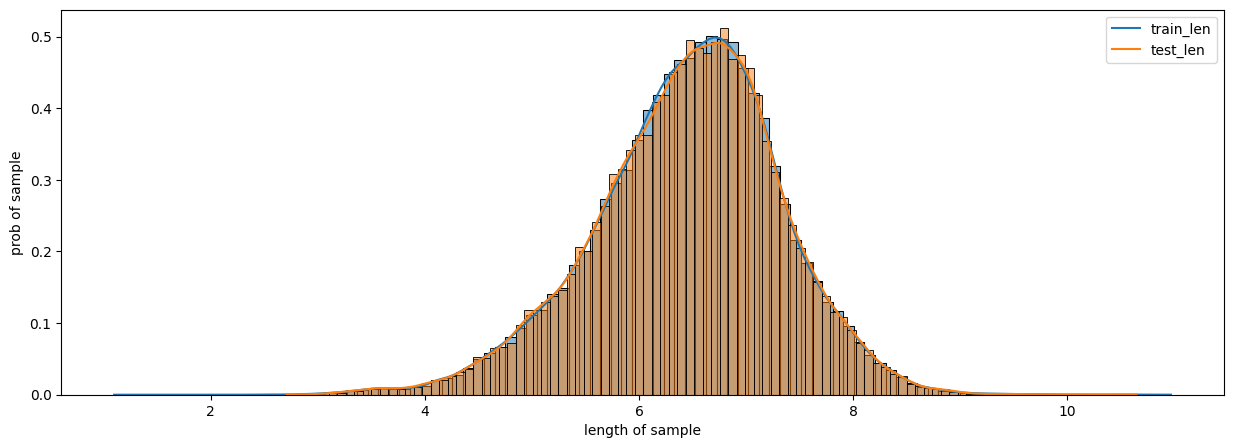

In [13]:
log_len_dist = np.log(1+len_dist)
log_len_test_dist = np.log(1+len_test_dist)
plt.figure(figsize=(15,5))
ax = sns.histplot(log_len_dist, bins=100, kde=True, stat="density")
ax = sns.histplot(log_len_test_dist, bins=100, kde=True, stat="density")
plt.xlabel("length of sample")
plt.ylabel("prob of sample")
plt.legend(['train_len','test_len'])



In [14]:
_, lognormal_ks_pvalue = stats.kstest(rvs=log_len_dist, cdf="norm")
lognormal_ks_pvalue

np.float64(0.0)

lognormal_ks_pvalue 是通过 K-S 检验（Kolmogorov-Smirnov 检验） 得到的 P 值，用于判断 log_len_dist 这个数据是否符合正态分布。

具体解释：

K-S 检验的作用

代码中 stats.kstest(rvs=log_len_dist, cdf="norm") 是在做一个假设检验：

    原假设（H₀）：log_len_dist 这个数据样本服从 正态分布（cdf="norm" 指定了参考的理论分布是正态分布）。

    备择假设（H₁）：log_len_dist 不服从正态分布。

P 值（lognormal_ks_pvalue）的含义


P 值表示：在原假设成立的前提下，观察到当前数据（或更极端数据）的概率。

如果 lognormal_ks_pvalue 较大（如 > 0.05）：
说明在 “数据服从正态分布” 的假设下，当前数据出现的概率较高，没有足够证据拒绝原假设，可以认为数据近似符合正态分布。

如果 lognormal_ks_pvalue 较小（如 < 0.05）：
说明在 “数据服从正态分布” 的假设下，当前数据出现的概率极低（属于 “小概率事件”），有足够证据拒绝原假设，即数据不符合正态分布。

In [24]:
trans_data, lam = stats.boxcox(len_dist+1)
statistic, pvalue = stats.normaltest(trans_data)
statistic, pvalue 

(np.float64(1347.7935885398067), np.float64(2.1396408275457613e-293))

总结：数据不符合正态分布，理论上无法应用正态分布的3sigma原则进行异常数据截断

但总归是要猜一个截断值的。看log图上8.5的位置比较靠谱。np.exp(8.5)=4914约等于5000，因此我初步决定把截断长度定为5000。

## 3、类别信息

简单查看类别信息表

先改造一下df_train，多加几个字段，分别是：

text-split，将text字段分词

len，每条新闻长度

first_char，新闻第一个字符

last_char，新闻最后一个字符

most_freq，新闻最常出现的字符

In [26]:
df_train["text_split"] = df_train["text"].apply(lambda x: x.split())
df_train["len"] = df_train["text"].apply(lambda x: len(x.split()))
df_train["first_char"] = df_train["text_split"].apply(lambda x: x[0])
df_train["last_char"] = df_train["text_split"].apply(lambda x: x[-1])
df_train["most_freq"] = df_train["text_split"].apply(lambda x: np.argmax(np.bincount(x)))
df_train.head()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5488\1519566339.py:5: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  df_train["most_freq"] = df_train["text_split"].apply(lambda x: np.argmax(np.bincount(x)))


,label,text,text_split,len,first_char,last_char,most_freq
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...,"[2967, 6758, 339, 2021, 1854, 3731, 4109, 3792...",1057,2967,1635,3750
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...,"[4464, 486, 6352, 5619, 2465, 4802, 1452, 3137...",486,4464,900,3750
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...,"[7346, 4068, 5074, 3747, 5681, 6093, 1777, 222...",764,7346,57,3750
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...,"[7159, 948, 4866, 2109, 5520, 2490, 211, 3956,...",1570,7159,2662,3750
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...,"[3646, 3055, 3055, 2490, 4659, 6065, 3370, 581...",307,3646,1635,3055


构建一个类别信息表。

count，该类别新闻个数

len_mean，该类别新闻平均长度

len_std，该类别新闻长度标准差

len_min，该类别新闻长度最小值

len_max，该类别新闻长度最大值

freq_fc，该类别新闻最常出现的第一个字符

freq_lc，该类别新闻最常出现的最后一个字符

freq_freq，该类别新闻最常出现的字符

In [29]:
df_train_info = pd.DataFrame(columns=["count", "len_mean", "len_std", "len_min", "len_max", "freq_fc", "freq_lc", "freq_freq"])
for name, group in df_train.groupby("label"):
    count = len(group)
    len_mean = np.mean(group["len"])
    len_std = np.std(group["len"])
    len_min = np.min(group["len"])
    len_max = np.max(group["len"])
    freq_fc = np.argmax(np.bincount(group["first_char"]))
    freq_lc = np.argmax(np.bincount(group["last_char"]))
    freq_freq = np.argmax(np.bincount(group["most_freq"]))
    df_train_info.loc[name] = [count, len_mean, len_std, len_min, len_max, freq_fc, freq_lc, freq_freq]
df_train_info

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5488\2060996542.py:8: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  freq_fc = np.argmax(np.bincount(group["first_char"]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5488\2060996542.py:9: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  freq_lc = np.argmax(np.bincount(group["last_char"]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5488\2060996542.py:8: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  freq_fc = np.argmax(np.bincount(group["first_char"]))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5488\2060996542.py:9: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
 

,count,len_mean,len_std,len_min,len_max,freq_fc,freq_lc,freq_freq
0,38918.0,878.717663,859.302990,12.0,18587.0,2400.0,900.0,3750.0
1,36945.0,870.363676,1451.060541,9.0,57921.0,1141.0,900.0,3750.0
2,31425.0,1014.429562,737.313693,2.0,41894.0,1580.0,2662.0,3750.0
3,22133.0,784.774726,739.347231,17.0,10817.0,7346.0,900.0,3750.0
4,15016.0,649.705647,718.689556,25.0,14928.0,1141.0,900.0,3750.0
5,12232.0,1116.054938,910.002484,27.0,15839.0,5744.0,900.0,3750.0
6,9985.0,1249.114071,1203.464887,16.0,25728.0,3659.0,900.0,3750.0
7,8841.0,1157.883271,942.048602,11.0,14469.0,6835.0,900.0,3750.0
8,7847.0,712.401172,898.704321,7.0,15271.0,913.0,900.0,3750.0
9,5878.0,833.627084,739.593276,17.0,23866.0,7346.0,900.0,3750.0


类别分布

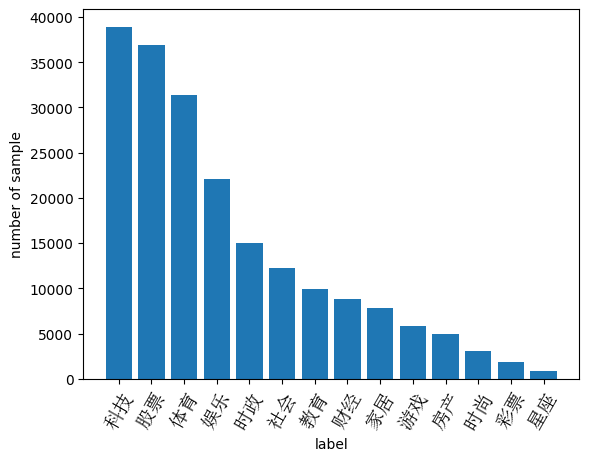

In [46]:
zhfont = FontProperties(fname="C:/Windows/Fonts/simsun.ttc", size=14) # 用于设置中文字体属性
label_2_index_dict = {'科技': 0, '股票': 1, '体育': 2, '娱乐': 3, '时政': 4, '社会': 5, '教育': 6, '财经': 7, '家居': 8, '游戏': 9, '房产': 10, '时尚': 11, '彩票': 12, '星座': 13}
index_2_label_dict = {v: k for k, v in label_2_index_dict.items()}

plt.figure()
plt.bar(x=range(14), height=np.bincount(df_train["label"]))
plt.xlabel("label")
plt.ylabel("number of sample")
plt.xticks(range(14), list(index_2_label_dict.values()), fontproperties=zhfont, rotation=60)
plt.show()

从统计结果可以看出:

赛题的数据集类别分布存在较为不均匀的情况。在训练集中科技类新闻最多，其次是股票类新闻，最少的新闻是星座新闻。

由于类别不均衡，会严重影响模型的精度。但是我们也是有办法应对的。

类别长度

([<matplotlib.axis.XTick at 0x1c5159a6780>,
 [Text(0, 0, '科技'),
  Text(1, 0, '股票'),
  Text(2, 0, '体育'),
  Text(3, 0, '娱乐'),
  Text(4, 0, '时政'),
  Text(5, 0, '社会'),
  Text(6, 0, '教育'),
  Text(7, 0, '财经'),
  Text(8, 0, '家居'),
  Text(9, 0, '游戏'),
  Text(10, 0, '房产'),
  Text(11, 0, '时尚'),
  Text(12, 0, '彩票'),
  Text(13, 0, '星座')])

<Figure size 640x480 with 0 Axes>

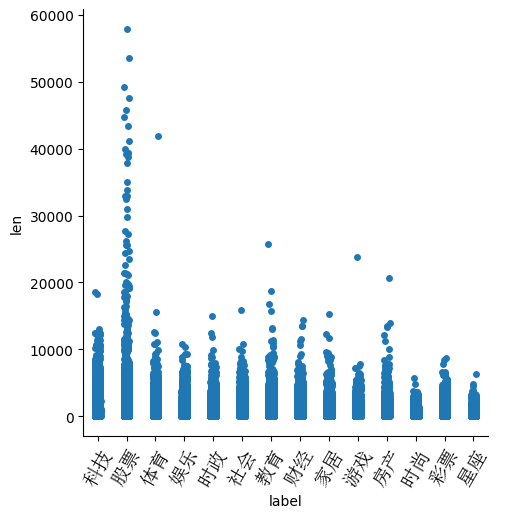

In [47]:
df_train["len"] = df_train["text"].apply(lambda x: len(x.split()))
plt.figure()
ax = sns.catplot(x="label", y="len", data=df_train, kind="strip")
plt.xticks(range(14), list(index_2_label_dict.values()), fontproperties=zhfont, rotation=60)

不同类别的文章长度不同，可以把长度作为一个Feature，以供机器学习模型训练

字符分布

训练集中总共包括6869个字，最大数字为7549，最小数字为0，其中编号3750的字出现的次数最多，编号3133的字出现的次数最少，仅出现一次。

In [ ]:
# 内存警告！！！没有8G内存不要运行该代码
all_lines = ' '.join(list(df_train['text']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse=True)

print(len(word_count))
# 6869

print(word_count[0])
# ('3750', 7482224)

print(word_count[-1])
# ('3133', 1)

下面代码统计了不同字符在多少个句子中出现过，其中字符3750、字符900和字符648在20w新闻的覆盖率接近99%，很有可能是标点符号。

In [ ]:
%%time
df_train['text_unique'] = df_train['text'].apply(lambda x: ' '.join(list(set(x.split(' ')))))
all_lines = ' '.join(list(df_train['text_unique']))
word_count = Counter(all_lines.split(" "))
word_count = sorted(word_count.items(), key=lambda d:int(d[1]), reverse=True)
# 打印整个训练集中覆盖率前5的词
for i in range(5):
    print("{} occurs {} times, {}%".format(word_count[i][0], word_count[i][1], (word_count[i][1]/200000)*100))

分析总结

1、训练集共200,000条新闻，每条新闻平均907个字符，最短的句子长度为2，最长的句子长度为57921，其中75%以下的数据长度在1131以下。测试集共50,000条新闻，每条新闻平均909个字符，最短句子长度为14，最长句子41861,75%以下的数据长度在1133以下。

2、训练集和测试集就长度来说似乎是同一分布，但是不属于正态分布。

3、赛题的数据集类别分布存在较为不均匀的情况。在训练集中科技类新闻最多，其次是股票类新闻，最少的新闻是星座新闻。需要用采样方法解决。文章最长的是股票类新闻。不同类别的文章长度不同，可以把长度和句子个数作为一个Feature，以供机器学习模型训练。

4、训练集中总共包括6869个字，最大数字为7549，最小数字为0，其中编号3750的字出现的次数最多，编号3133的字出现的次数最少，仅出现一次，其中字符3750、字符900和字符648在20w新闻的覆盖率接近99%，很有可能是标点符号。

5、900很有可能是句号，2662和885则很有可能为感叹号和问号，3750出现频率很高但是基本不在新闻最后出现，因此初步判断为逗号。按照这种划分，训练集中每条新闻平均句子个数约为19。

6、在训练集中，不同类别新闻出现词汇有特色。但是需要把共有的常用词停用。自然想到利用TF-IDF编码方式。